In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data of top Enron executives. The Enron datasets comprising emails and financial data of Enron were made available to the public for research and analysis and can be downloaded from https://www.cs.cmu.edu/~./enron/.

The goal of this assignment is to use machine learning to build a POI (Person of Interest) identifier based on financial and email data made public. Here, 'person of interest' refers to a person who is charged by the law for committing a crime, in this case, the scandal at Enron.

I found a dataset that aligned with the POI identification on Kaggle( https://www.kaggle.com/sagarnildass/enron-person-of-interest-dataset). I used this ddataset instead of using the original dataset.

In [130]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
import pickle

The dataset I found have a is in .pkl format. So, I have to use pickle module to unpack this data.

In [131]:
with open("dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

In [132]:
# Converting the given pickled Enron data to a pandas dataframe.
enron_df = pd.DataFrame.from_records(list(data_dict.values()))

# Set the index of df to be the employees series:
employees = pd.Series(list(data_dict.keys()))
enron_df.set_index(employees, inplace=True)
enron_df

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788,807,NaN,1061827,NaN,600000,mark.metts@enron.com,NaN,NaN,585062,...,38,NaN,29,1740,1,False,NaN,702,585062,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
ELLIOTT STEVEN,170941,NaN,NaN,211725,NaN,350000,steven.elliott@enron.com,NaN,-400729,6678735,...,NaN,4890344,NaN,12961,NaN,False,NaN,NaN,1788391,NaN
CORDES WILLIAM R,NaN,764,NaN,NaN,NaN,NaN,bill.cordes@enron.com,NaN,NaN,1038185,...,10,651850,12,NaN,0,False,NaN,58,386335,NaN
HANNON KEVIN P,243293,1045,NaN,288682,NaN,1500000,kevin.hannon@enron.com,NaN,-3117011,6391065,...,32,5538001,32,11350,21,True,1617011,1035,853064,NaN
MORDAUNT KRISTINA M,267093,NaN,NaN,628522,NaN,325000,kristina.mordaunt@enron.com,NaN,NaN,208510,...,NaN,NaN,NaN,1411,NaN,False,NaN,NaN,208510,NaN
MEYER ROCKFORD G,NaN,232,1848227,1848227,NaN,NaN,rockford.meyer@enron.com,NaN,NaN,955873,...,0,493489,28,NaN,0,False,NaN,22,462384,NaN
MCMAHON JEFFREY,370448,2355,NaN,4099771,NaN,2600000,jeffrey.mcmahon@enron.com,NaN,NaN,1662855,...,58,1104054,48,297353,26,False,694862,2228,558801,NaN
HAEDICKE MARK E,374125,4009,2157527,3859065,NaN,1150000,mark.haedicke@enron.com,-329825,-934484,803094,...,180,608750,1941,52382,61,False,983346,1847,524169,NaN
PIPER GREGORY F,197091,1238,1130036,1737629,NaN,400000,greg.piper@enron.com,-409554,-33333,880290,...,61,880290,222,778,48,False,NaN,742,409554,NaN


In [133]:
print ("Size of the enron dataframe: ", enron_df.shape)
print ("Number of data points (people) in the dataset: ", len(enron_df))
print ("Number of Features in the Enron Dataset: ", len(enron_df.columns))

Size of the enron dataframe:  (146, 21)
Number of data points (people) in the dataset:  146
Number of Features in the Enron Dataset:  21


In [134]:
poi_count = enron_df.groupby('poi').size()
print ("Total number of POI's in the given dataset: ", poi_count.iloc[1])
print ("Total number of non-POI's in the given dataset: ", poi_count.iloc[0])

Total number of POI's in the given dataset:  18
Total number of non-POI's in the given dataset:  128


In [135]:
enron_df.dtypes


salary                       object
to_messages                  object
deferral_payments            object
total_payments               object
loan_advances                object
bonus                        object
email_address                object
restricted_stock_deferred    object
deferred_income              object
total_stock_value            object
expenses                     object
from_poi_to_this_person      object
exercised_stock_options      object
from_messages                object
other                        object
from_this_person_to_poi      object
poi                            bool
long_term_incentive          object
shared_receipt_with_poi      object
restricted_stock             object
director_fees                object
dtype: object

In [136]:
# Converting the datatypes in the given pandas dataframe 
# into floating points for analysis and replace NaN with zeros.

# Coerce numeric values into floats or ints; also change NaN to zero.
enron_df_new = enron_df.apply(lambda x : pd.to_numeric(x, errors = 'coerce')).copy().fillna(np.nan)
enron_df_new

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788.0,807.0,NaN,1061827.0,NaN,600000.0,NaN,NaN,NaN,585062.0,...,38.0,NaN,29.0,1740.0,1.0,False,NaN,702.0,585062.0,NaN
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,NaN,1200000.0,NaN,NaN,-1386055.0,10623258.0,...,NaN,6680544.0,NaN,2660303.0,NaN,False,1586055.0,NaN,3942714.0,NaN
ELLIOTT STEVEN,170941.0,NaN,NaN,211725.0,NaN,350000.0,NaN,NaN,-400729.0,6678735.0,...,NaN,4890344.0,NaN,12961.0,NaN,False,NaN,NaN,1788391.0,NaN
CORDES WILLIAM R,NaN,764.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1038185.0,...,10.0,651850.0,12.0,NaN,0.0,False,NaN,58.0,386335.0,NaN
HANNON KEVIN P,243293.0,1045.0,NaN,288682.0,NaN,1500000.0,NaN,NaN,-3117011.0,6391065.0,...,32.0,5538001.0,32.0,11350.0,21.0,True,1617011.0,1035.0,853064.0,NaN
MORDAUNT KRISTINA M,267093.0,NaN,NaN,628522.0,NaN,325000.0,NaN,NaN,NaN,208510.0,...,NaN,NaN,NaN,1411.0,NaN,False,NaN,NaN,208510.0,NaN
MEYER ROCKFORD G,NaN,232.0,1848227.0,1848227.0,NaN,NaN,NaN,NaN,NaN,955873.0,...,0.0,493489.0,28.0,NaN,0.0,False,NaN,22.0,462384.0,NaN
MCMAHON JEFFREY,370448.0,2355.0,NaN,4099771.0,NaN,2600000.0,NaN,NaN,NaN,1662855.0,...,58.0,1104054.0,48.0,297353.0,26.0,False,694862.0,2228.0,558801.0,NaN
HAEDICKE MARK E,374125.0,4009.0,2157527.0,3859065.0,NaN,1150000.0,NaN,-329825.0,-934484.0,803094.0,...,180.0,608750.0,1941.0,52382.0,61.0,False,983346.0,1847.0,524169.0,NaN
PIPER GREGORY F,197091.0,1238.0,1130036.0,1737629.0,NaN,400000.0,NaN,-409554.0,-33333.0,880290.0,...,61.0,880290.0,222.0,778.0,48.0,False,NaN,742.0,409554.0,NaN


In [137]:
# Dropping column 'email_address' as it is not required in analysis.
enron_df_new.drop('email_address', axis = 1, inplace = True)

# Checking the changed shape of df.
enron_df_new.shape

(146, 20)

### Outlier Investigation & Analyzing the Features 

The features can be categorized as the following.

**Financial Features (in US dollars):**<br>
``salary
deferral_payments
total_payments
loan_advances
bonus
restricted_stock_deferred
deferred_income
total_stock_value
expenses
exercised_stock_options
other
long_term_incentive
restricted_stock
director_fees``

**Email Features (count of emails):**<br>
``to_messages
email_address
from_poi_to_this_person
from_messages
from_this_person_to_poi
shared_receipt_with_poi``

**POI Labels (boolean):**<br>
``poi``


Drawing scatterplot of **Bonus vs Salary** of Enron employees.

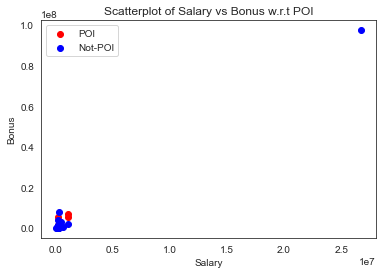

In [138]:
plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == True],
            enron_df_new['bonus'][enron_df_new['poi'] == True], 
            color = 'r', label = 'POI')

plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == False],
            enron_df_new['bonus'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Scatterplot of Salary vs Bonus w.r.t POI")
plt.legend(loc='upper left')
plt.show() 

It can be noted from the above figure, one non-POI point has very high value of salary and bonus. Checking for the concerned point.

In [139]:
# Finding the non-POI employee having maximum salary
enron_df_new[enron_df_new['salary']==enron_df_new['salary'].max()]

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
TOTAL,26704229.0,NaN,32083396.0,309886585.0,83925000.0,97343619.0,-7576788.0,-27992891.0,434509511.0,5235198.0,NaN,311764000.0,NaN,42667589.0,NaN,False,48521928.0,NaN,130322299.0,1398517.0


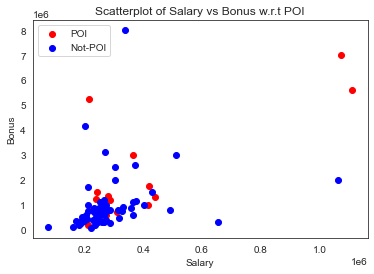

In [140]:
# Deleting the row 'Total' from the dataframe
enron_df_new.drop('TOTAL', axis = 0, inplace = True)

# Drawing scatterplot with the modified dataframe
plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == True],
            enron_df_new['bonus'][enron_df_new['poi'] == True], 
            color = 'r', label = 'POI')

plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == False],
            enron_df_new['bonus'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Scatterplot of Salary vs Bonus w.r.t POI")
plt.legend(loc='upper left')
plt.show() 

From the above figure, it is observed that the data becomes more spread out and more comprehensible after the outlier removal. Its also observed **that values of bonuses of POIs are higher than that of non-POIs**.

As the POI's were taking larger amounts of money as a bonus, in addition to their high salary, it can be stated that the ratio of bonus to the salary of the POI's will be higher as compared to that of non-POI's. Hence, **a new feature called bonus-to-salary_ratio is created** in the hope that it may aid in the POI identification later.

In [141]:
enron_df_new['bonus-to-salary_ratio'] = enron_df_new['bonus']/enron_df_new['salary']

#### Removing Outlier: 'THE TRAVEL AGENCY IN THE PARK.'

It is known that Enron had made up some transactions with bogus companies and people. So on observing the features of this dataset, it can be considered as an outlier with very low values in all features except in _others_ and _total-payments_. Hence, it is removed. 

In [142]:
# Features of the index 'THE TRAVEL AGENCY IN THE PARK'
enron_df_new.loc['THE TRAVEL AGENCY IN THE PARK']

salary                          NaN
to_messages                     NaN
deferral_payments               NaN
total_payments               362096
loan_advances                   NaN
bonus                           NaN
restricted_stock_deferred       NaN
deferred_income                 NaN
total_stock_value               NaN
expenses                        NaN
from_poi_to_this_person         NaN
exercised_stock_options         NaN
from_messages                   NaN
other                        362096
from_this_person_to_poi         NaN
poi                           False
long_term_incentive             NaN
shared_receipt_with_poi         NaN
restricted_stock                NaN
director_fees                   NaN
bonus-to-salary_ratio           NaN
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object

In [143]:
# Deleting the row with index 'THE TRAVEL AGENCY IN THE PARK'
enron_df_new.drop('THE TRAVEL AGENCY IN THE PARK', axis = 0, inplace = True)

#### Financial Features: `deferred_income`, `deferred_payment` and `total_payment`
According to Google, 

Deferred payment is temporary postponement of the payment of an outstanding bill or debt, usually involving repayment by instalments.

Deferred income (also known as deferred revenue, unearned revenue, or unearned income) is money received for goods or services which has not yet been earned. According to the revenue recognition principle, it is recorded as a liability until delivery is made, at which time it is converted into revenue..

As Enron scam involved a lot of undisclosed assets and cheating public by selling assets to shell companies at the end of each month and repurchasing them at the start of next month to hide the accounting losses, there are chances that a lot of deferred revenue by the company was used by the POIs.

In [144]:
enron_df_new['deferred_income'].describe()

count    4.800000e+01
mean    -5.810498e+05
std      9.420764e+05
min     -3.504386e+06
25%     -6.112092e+05
50%     -1.519270e+05
75%     -3.792600e+04
max     -8.330000e+02
Name: deferred_income, dtype: float64

The **deferred_income** feature has mostly negative values as it is the money which has to be returned by the company.

In [145]:
# Finding out the integer index locations of POIs and non-POIs.
poi_rs = []
non_poi_rs = []
for i in range(len(enron_df_new['poi'])):
    if enron_df_new['poi'][i] == True:
        poi_rs.append(i+1)
    else:
        non_poi_rs.append(i+1)

print("Length of poi list: ", len(poi_rs))
print("Length non-poi list: ", len(non_poi_rs))

Length of poi list:  18
Length non-poi list:  126


Drawing a scatterplot of **Employees with deferred income**

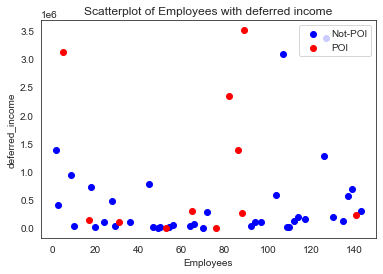

In [146]:
#Since 'deferred_income' is negative, for intuitive understanding,
# a positive person of the variable is created for visualization.
enron_df_new['deferred_income_p'] = enron_df_new['deferred_income'] * -1

plt.scatter(non_poi_rs,
            enron_df_new['deferred_income_p'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(poi_rs,
            enron_df_new['deferred_income_p'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')
    
plt.xlabel('Employees')
plt.ylabel('deferred_income')
plt.title("Scatterplot of Employees with deferred income")
plt.legend(loc='upper right')
plt.show()

The above scatterplot is not much helpful in either detecting outliers or finding patterns as some POIs as well as non-POIs have high values of deferred income. Although, a very trend does suggest POIs to have higher deferred income.

Creating a scatterplot of **`total_payments` vs `deferral_payments` w.r.t `POI`**.

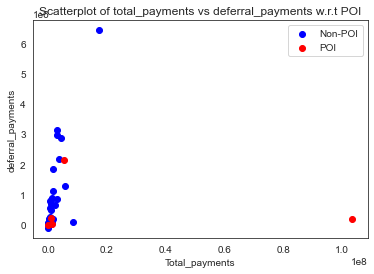

In [147]:
# Scatterplot of total_payments vs deferral_payments w.r.t POI
plt.scatter(enron_df_new['total_payments'][enron_df_new['poi'] == False],
            enron_df_new['deferral_payments'][enron_df_new['poi'] == False],
            color = 'b', label = 'Non-POI')

plt.scatter(enron_df_new['total_payments'][enron_df_new['poi'] == True],
            enron_df_new['deferral_payments'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

plt.xlabel('Total_payments')
plt.ylabel('deferral_payments')
plt.title("Scatterplot of total_payments vs deferral_payments w.r.t POI")
plt.legend(loc='upper right')
plt.show()

From the above scatterplot, it can be observed that the majority of POIs have a less value of deferral payments as compared to the deferral_payments of non-POIs. We can also observe there are two outliers. The one having a high value of total_payments is a POI, and the other outlier with a high value of deferral payments is a non-POI. Removing the non-POI outlier.

In [148]:
# Finding the non-POI employee having maximum 'deferral_payments'
enron_df_new[enron_df_new['deferral_payments']==enron_df_new['deferral_payments'].max()]

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,...,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,bonus-to-salary_ratio,deferred_income_p
FREVERT MARK A,1060932.0,3275.0,6426990.0,17252530.0,2000000.0,2000000.0,NaN,-3367011.0,14622185.0,86987.0,...,21.0,7427621.0,6.0,False,1617011.0,2979.0,4188667.0,NaN,1.885135,3367011.0


In [149]:
# Removing the non-POI employee having maximum 'deferral_payments'
enron_df_new.drop('FREVERT MARK A', axis = 0, inplace = True)

#### Financial Features : `long_term_incentive`

Making a scatterplot to check the `long_term_incentive` of different Enron employees.

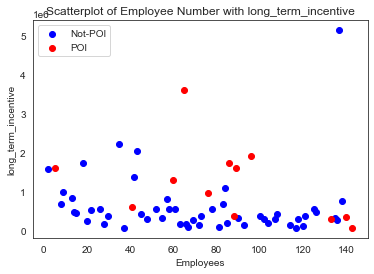

In [150]:
poi_rs = []
non_poi_rs = []
for i in range(len(enron_df_new['poi'])):
    if enron_df_new['poi'][i] == True:
        poi_rs.append(i+1)
    else:
        non_poi_rs.append(i+1)

# Making a scatterplot
plt.scatter(non_poi_rs,
            enron_df_new['long_term_incentive'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(poi_rs,
            enron_df_new['long_term_incentive'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

plt.xlabel('Employees')
plt.ylabel('long_term_incentive')
plt.title("Scatterplot of Employee Number with long_term_incentive")
plt.legend(loc='upper left')
plt.show()

One employee has a very high value of `long_term_incentive`, so considering this point as an outlier and removing it.  

In [151]:
enron_df_new[enron_df_new['long_term_incentive']==enron_df_new['long_term_incentive'].max()]

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,...,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,bonus-to-salary_ratio,deferred_income_p
MARTIN AMANDA K,349487.0,1522.0,85430.0,8407016.0,NaN,NaN,NaN,NaN,2070306.0,8211.0,...,230.0,2818454.0,0.0,False,5145434.0,477.0,NaN,NaN,NaN,NaN


In [152]:
enron_df_new.drop('MARTIN AMANDA K', axis = 0, inplace = True)

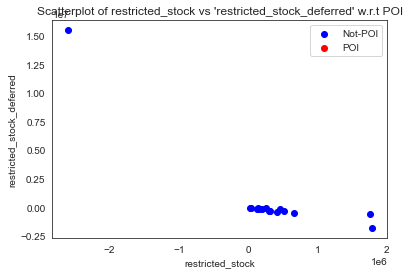

In [153]:
# Scatterplot of restricted_stock vs 'restricted_stock_deferred' w.r.t POI

plt.scatter(enron_df_new['restricted_stock'][enron_df_new['poi'] == False],
            enron_df_new['restricted_stock_deferred'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['restricted_stock'][enron_df_new['poi'] == True],
            enron_df_new['restricted_stock_deferred'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('restricted_stock')
plt.ylabel('restricted_stock_deferred')
plt.title("Scatterplot of restricted_stock vs 'restricted_stock_deferred' w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

In [154]:
enron_df_new[enron_df_new['restricted_stock_deferred']==enron_df_new['restricted_stock_deferred'].max()]

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,...,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,bonus-to-salary_ratio,deferred_income_p
BHATNAGAR SANJAY,NaN,523.0,NaN,15456290.0,NaN,NaN,15456290.0,NaN,NaN,NaN,...,29.0,137864.0,1.0,False,NaN,463.0,-2604490.0,137864.0,NaN,NaN


There is a outlier in the feature restricted_stock_deferred. Taking a quick look at the values of restricted_stock_deferred most of the values are zeros, and the remaining few are negative values. The outlier found here is the Enron employee 'BHATNAGAR SANJAY' who is not a POI. Hence, this datapoint is removed. There is no exciting observation in the other axis of this graph.

In [155]:
enron_df_new.drop('BHATNAGAR SANJAY', axis = 0, inplace = True)

#### Email Features : ` from_poi_to_this_person` and `from_this_person_to_poi`

Given that the dataset is related to the emails, it can be thought that for doing such a big scam, the POI's might frequently have communication between them via E-mails. Hence, by checking on the number of e-mails transferred between POIs and an Employee, we can guess for the involvement of that person in that scam.

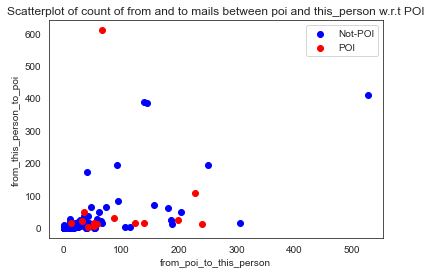

In [156]:
plt.scatter(enron_df_new['from_poi_to_this_person'][enron_df_new['poi'] == False],
            enron_df_new['from_this_person_to_poi'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['from_poi_to_this_person'][enron_df_new['poi'] == True],
            enron_df_new['from_this_person_to_poi'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('from_poi_to_this_person')
plt.ylabel('from_this_person_to_poi')
plt.title("Scatterplot of count of from and to mails between poi and this_person w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

This scatterplot shows the relationship between the count of emails sent to and fro among different employees of Enron. I think a different feature showing the proportion of mail sent by employees and POI to each other will be more helpful in finding the POI. As POIs are more likely to have more communications with other POIs as compared to communication with other non-POIS, **two new features are created.**

#### Features created: `fraction_mail_from_poi` and `fraction_mail_to_poi` <a id=#new_features_2></a>

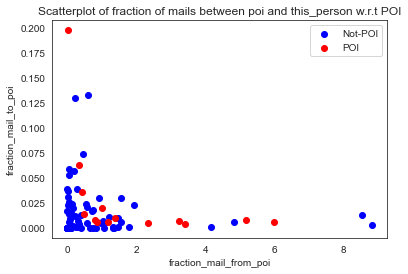

In [157]:
enron_df_new['fraction_mail_from_poi'] = enron_df_new['from_poi_to_this_person']/enron_df_new['from_messages'] 
enron_df_new['fraction_mail_to_poi'] = enron_df_new['from_this_person_to_poi']/enron_df_new['to_messages']

# Scatterplot of fraction of mails from and to between poi and this_person w.r.t POI
plt.scatter(enron_df_new['fraction_mail_from_poi'][enron_df_new['poi'] == False],
            enron_df_new['fraction_mail_to_poi'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['fraction_mail_from_poi'][enron_df_new['poi'] == True],
            enron_df_new['fraction_mail_to_poi'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('fraction_mail_from_poi')
plt.ylabel('fraction_mail_to_poi')
plt.title("Scatterplot of fraction of mails between poi and this_person w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

From the above figure, the difference between POIs and non-POI points can be clearly classified. The red dots representing POIs are more distinct, have higher values and are more separate from the non-POI blue points.

In [158]:
# Clean all 'inf' values which we got if the person's from_messages = 0
enron_df_new = enron_df_new.replace('inf', 0)
enron_df_new = enron_df_new.fillna(0)


In [159]:
enron_df_new

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,...,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,bonus-to-salary_ratio,deferred_income_p,fraction_mail_from_poi,fraction_mail_to_poi
METTS MARK,365788.0,807.0,0.0,1061827.0,0.0,600000.0,0.0,0.0,585062.0,94299.0,...,1.0,False,0.0,702.0,585062.0,0.0,1.640294,0.0,1.310345,0.001239
BAXTER JOHN C,267102.0,0.0,1295738.0,5634343.0,0.0,1200000.0,0.0,-1386055.0,10623258.0,11200.0,...,0.0,False,1586055.0,0.0,3942714.0,0.0,4.492666,1386055.0,0.000000,0.000000
ELLIOTT STEVEN,170941.0,0.0,0.0,211725.0,0.0,350000.0,0.0,-400729.0,6678735.0,78552.0,...,0.0,False,0.0,0.0,1788391.0,0.0,2.047490,400729.0,0.000000,0.000000
CORDES WILLIAM R,0.0,764.0,0.0,0.0,0.0,0.0,0.0,0.0,1038185.0,0.0,...,0.0,False,0.0,58.0,386335.0,0.0,0.000000,0.0,0.833333,0.000000
HANNON KEVIN P,243293.0,1045.0,0.0,288682.0,0.0,1500000.0,0.0,-3117011.0,6391065.0,34039.0,...,21.0,True,1617011.0,1035.0,853064.0,0.0,6.165405,3117011.0,1.000000,0.020096
MORDAUNT KRISTINA M,267093.0,0.0,0.0,628522.0,0.0,325000.0,0.0,0.0,208510.0,35018.0,...,0.0,False,0.0,0.0,208510.0,0.0,1.216805,0.0,0.000000,0.000000
MEYER ROCKFORD G,0.0,232.0,1848227.0,1848227.0,0.0,0.0,0.0,0.0,955873.0,0.0,...,0.0,False,0.0,22.0,462384.0,0.0,0.000000,0.0,0.000000,0.000000
MCMAHON JEFFREY,370448.0,2355.0,0.0,4099771.0,0.0,2600000.0,0.0,0.0,1662855.0,137108.0,...,26.0,False,694862.0,2228.0,558801.0,0.0,7.018529,0.0,1.208333,0.011040
HAEDICKE MARK E,374125.0,4009.0,2157527.0,3859065.0,0.0,1150000.0,-329825.0,-934484.0,803094.0,76169.0,...,61.0,False,983346.0,1847.0,524169.0,0.0,3.073839,934484.0,0.092736,0.015216
PIPER GREGORY F,197091.0,1238.0,1130036.0,1737629.0,0.0,400000.0,-409554.0,-33333.0,880290.0,43057.0,...,48.0,False,0.0,742.0,409554.0,0.0,2.029519,33333.0,0.274775,0.038772


This is a feature formating function that I found along with the dataset on https://www.kaggle.com/sagarnildass/enron-person-of-interest-dataset

In [160]:
def featureFormat( dictionary, features, remove_NaN=True,
                    remove_all_zeroes=True, remove_any_zeroes=False,
                    sort_keys = False):
    return_list = []

    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print("error: key ", feature, " not present")
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        append = True

        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list

        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True

        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False

        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)

def targetFeatureSplit( data ):
   
    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )

    return target, features


In [161]:
enron_dict = enron_df_new.to_dict('index')
dataset = enron_dict

In [162]:
features_list = ['poi', 'salary', 'bonus', 'long_term_incentive', 'bonus-to-salary_ratio', 'deferral_payments', 'expenses', 
                 'restricted_stock_deferred', 'restricted_stock', 'deferred_income','fraction_mail_from_poi', 'total_payments',
                 'other', 'fraction_mail_to_poi', 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 
                 'from_messages', 'shared_receipt_with_poi', 'loan_advances', 'director_fees', 'exercised_stock_options',
                'total_stock_value']

In [163]:
data = featureFormat(dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

**1. Feature Scaling:** `MinMaxScaler` is used which scales features to lie between zero and one. MinMaxScaler transforms features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set, i.e., between zero and one. It is also limited to be used with algorithms that involve distance measures to avoid loss of information.

**2. Feature Selection**: Feature selection/dimensionality reduction on sample sets is essential to improve estimators’ accuracy scores, boost performance & simplification of the model. In this project, `SelectKBest` to find the 'K' best or high-scoring features. Objects of these functions, take as input a scoring function that returns univariate scores and p-values. Here, `f_classif` is used as the scoring function which computes the ANOVA F-value between labels and features for classification tasks.  


In [164]:
# Split data into training and testing datasets
from sklearn.model_selection import train_test_split
features_train, features_test,labels_train, labels_test = train_test_split(features, labels, 
                                                              test_size=0.3, random_state=42)

# Stratified ShuffleSplit cross-validator
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.3, random_state = 42)

# Importing modules for feature scaling and selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#1. Feature scaling
scaler = MinMaxScaler()

# 2. Feature Selection
skb = SelectKBest(f_classif)

In [165]:
features_selected_bool = grid.best_estimator_.named_steps['SKB'].get_support()

features_selected_list = [x for x, y in zip(features_list[1:], features_selected_bool) if y]

print("Total number of features selected by SelectKBest algorithm: ", len(features_selected_list))
# Finding the score of features 
feature_scores =  grid.best_estimator_.named_steps['SKB'].scores_

# Finding the score of features selected by selectKBest
feature_selected_scores = feature_scores[features_selected_bool]

# Creating a pandas dataframe and arranging the features based on their scores and ranking them 
imp_features_df = pd.DataFrame({'Features_Selected':features_selected_list, 'Features_score':feature_selected_scores})
imp_features_df.sort_values('Features_score', ascending = False, inplace = True)
Rank = pd.Series(list(range(1, len(features_selected_list)+1)))
imp_features_df.set_index(Rank, inplace = True)

print("The following table shows the feature selected along with its corresponding scores.")
imp_features_df


Total number of features selected by SelectKBest algorithm:  9
The following table shows the feature selected along with its corresponding scores.


,Features_Selected,Features_score
1,deferred_income,13.287587
2,bonus,12.438591
3,salary,12.225775
4,exercised_stock_options,11.166453
5,fraction_mail_from_poi,10.598733
6,total_stock_value,10.191784
7,long_term_incentive,10.164526
8,bonus-to-salary_ratio,9.869367
9,total_payments,9.361047


I used following models
1. KNN (K-Nearest Neighbour)
2. Gaussian Naive Bayes Classifier

In [166]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [167]:
clf_knn = KNeighborsClassifier()

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state = 42)
pipeline = Pipeline(steps = [("scaling", scaler), ("SKB", skb),  ("knn",clf_knn)])
param_grid = {"SKB__k":[3,4,5,6,7,8,9,10,11,12,13,14,15, 16, 17, 18], 
              "knn__n_neighbors": [3,4,5,6,7,8,9,11,12,13,15],
              }

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = sss, scoring = 'f1')


# clf = clf.fit(features_train, labels_train)
grid.fit(features, labels)


# Best Algorithm
clf = grid.best_estimator_

# Refit the best algorithm:
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)


# Evaluation measures
print("Accuracy of KNN  : ", accuracy_score(labels_test, prediction))
print("Precision of KNN : ", precision_score(prediction, labels_test))
print("Recall of KNN   : ", recall_score(prediction, labels_test))
print("f1-score of KNN  : ", f1_score(prediction, labels_test))

Accuracy of KNN  :  0.8809523809523809
Precision of KNN :  0.3333333333333333
Recall of KNN   :  0.6666666666666666
f1-score of KNN  :  0.4444444444444444


In [168]:
clf_gnb = GaussianNB()

pipeline = Pipeline(steps = [("SKB", skb), ("NaiveBayes", clf_gnb)])
param_grid = {"SKB__k":[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = sss, scoring = 'f1')


grid.fit(features, labels)


# Best Algorithm
clf = grid.best_estimator_


# Refit the best algorithm:
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)


print("Accuracy of GaussianNB is  : ", accuracy_score(labels_test, prediction))
print("Precision of GaussianNB is : ", precision_score(prediction, labels_test))
print("Recall of GaussianNB is    : ", recall_score(prediction, labels_test))
print("f1-score of GaussianNB is  : ", f1_score(prediction, labels_test))

Accuracy of GaussianNB is  :  0.8333333333333334
Precision of GaussianNB is :  0.5
Recall of GaussianNB is    :  0.42857142857142855
f1-score of GaussianNB is  :  0.4615384615384615


In total, two models were tried viz. Gaussian Naive Bayes, KNN (K-Nearest Neighbors). Gaussian Naïve Bayes was the best performing model amongst the models based on the f1-score and the precision and recall.